In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [206]:
from stylegan import G_synthesis,G_mapping
from functools import partial
from SphericalOptimizer import SphericalOptimizer
from edge_loss import EdgeLossBuilder
import time

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import DataParallel
from pathlib import Path
from PIL import Image
import torchvision
from math import log10, ceil

In [174]:
import numpy as np
import PIL
import PIL.Image
import sys
import os
import glob
import scipy
import scipy.ndimage
import dlib
from drive import open_url
from pathlib import Path
from edge_gen import EdgeGen
import torchvision
from shape_predictor import align_face

In [175]:
import matplotlib.pyplot as plt
import collections
import stylegan
import tempfile
import subprocess

In [176]:
device = "cuda:1"

In [177]:
import torch.nn as nn
import importlib  
DexiModule = importlib.import_module("DexiNed.DexiNed-Pytorch.model")

In [9]:
from torchvision import transforms#, utils
# normalize the predicted SOD probability map
def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)
    dn = (d-mi)/(ma-mi)
    return dn

U2NetModule = importlib.import_module("U-2-Net.model")
u2net = U2NetModule.U2NET(3,1)
u2net.load_state_dict(torch.load("U-2-Net/saved_models/u2net/u2net.pth"))
if torch.cuda.is_available():
    u2net.to(device)
u2net.eval()
for param in u2net.parameters():
    param.requires_grad = False

## Setup Everything

### Printing Images Utils

In [178]:
# expect im to be a torch tensor
def plt_print(im):
    def plt_print3(im3):
        c,h,w = im3.shape
        if c == 1:
            im_printable = im3[0]
        elif c == 3:
            im_printable = im3
        elif c == 4:
            im_printable = im3[:3]
        else:
            raise ValueError(f"Rank 3 Print Image Dimension Error: {im3.shape}")
            
        im_printable = im_printable.detach().cpu().numpy()
        if c in {3, 4}:
            im_printable = im_printable.transpose(1,2,0)
        plt.imshow(im_printable)
        plt.show()
    
    rank = len(im.shape)
    if rank == 4:
        b,c,h,w = im.shape
        assert b == 1
        plt_print3(im[0])
    elif rank == 3:
        c,h,w = im.shape
        plt_print3(im)
    elif rank == 2:
        h,w = im.shape
        plt.imshow(im.detach().cpu().numpy().transpose(1,2,0))
        plt.show()
    else:
        raise ValueError(f"Print Image Dimension Error: {im.shape}")

### Setting up PULSE

In [179]:
kwargs = dict(
    input_dir="sketches/1pixel",  # 'input data directory'
    output_dir='runs',  # 'output data directory'
    cache_dir='cache',  # 'cache directory for model weights'
    duplicates=1,  # 'How many HR images to produce for every image in the input directory'
    batch_size=1,  # 'Batch size to use during optimization'
    seed=0,  # 'manual seed to use'
    loss_str="1*BCE+0*L2+0.05*GEOCROSS",  # 100*L2+0.05*GEOCROSS 'Loss function to use'
    eps=2e-3,  # 'Target for downscaling loss (L2)'
    noise_type='trainable',  # 'zero, fixed, or trainable'
    num_trainable_noise_layers=5,  # 'Number of noise layers to optimize'
    tile_latent=False,  # 'Whether to forcibly tile the same latent 18 times'
    bad_noise_layers="17",  # 'List of noise layers to zero out to improve image quality')
    opt_name='diogo',  # 'Optimizer to use in projected gradient descent'
    learning_rate=0.4,  #  help='Learning rate to use during optimization'
    steps=200,  # 'Number of optimization steps'
    lr_schedule='linear1cycledrop',  # 'fixed, linear1cycledrop, linear1cycle'
    save_intermediate=False,  # 'Whether to store and save intermediate HR and LR images during optimization'
    device="cuda:1",
) 
device = kwargs["device"]
extra_kwargs = {}

In [224]:
def _logit(x):
    x = x.clamp(min=1e-8, max=1 - 1e-8)
    return torch.log(x / (1 - x))

def _gen_im_fg_edges(gen_im):
    mask = foreground_mask(gen_im)
    edge_logits = EdgeGen(device)(gen_im)
    mask = 0.1 + 0.9 * mask
    gen_im_fg_edges = _logit(mask * torch.sigmoid(edge_logits))
    return gen_im_fg_edges

def _loss_bce1(gen_im, ref_im, **kwargs):
    gen_im_edges = EdgeGen(device)(gen_im)
    weights = (ref_im == 0) / (ref_im == 0).to(torch.float16).mean() + (ref_im == 1) / (ref_im == 1).to(torch.float16).mean()
    bce = torch.nn.functional.binary_cross_entropy(torch.sigmoid(gen_im_edges), ref_im, weights)
    return bce

def _loss_bce2(gen_im, ref_im, **kwargs):
    gen_im_edges = EdgeGen(device)(gen_im)
    mask = (ref_im > 0.5).float()
    b, c, h, w = mask.shape
    num_pos = torch.sum(mask, dim=[1, 2, 3]).float()  # Shape: [b,].
    num_neg = c * h * w - num_pos                     # Shape: [b,].
    weight = torch.ones_like(mask)
    weight[ref_im > 0.5]  = num_pos / (num_pos + num_neg) # white
    weight[ref_im <= 0.5] = num_neg / (num_pos + num_neg) # black
    # Calculate loss.
    losses = torch.nn.functional.binary_cross_entropy(
        torch.sigmoid(gen_im_edges).float(), ref_im.float(), weight=weight, reduction='none')
    bce = torch.mean(losses) / b
    return bce

def _loss_bce3(gen_im, ref_im, **kwargs):
    gen_im_edges = EdgeGen(device)(gen_im)
    mask = (ref_im > 0.5).float()
    b, c, h, w = mask.shape
    num_pos = torch.sum(mask, dim=[1, 2, 3], keepdim=True).float()  # Shape: [b,].
    num_neg = c * h * w - num_pos                     # Shape: [b,].
    weight = torch.zeros_like(mask)
    #weight[edges > 0.5]  = num_neg / (num_pos + num_neg)
    #weight[edges <= 0.5] = num_pos / (num_pos + num_neg)
    weight.masked_scatter_(ref_im > 0.5,
        torch.ones_like(ref_im) * num_neg / (num_pos + num_neg))
    weight.masked_scatter_(ref_im <= 0.5,
        torch.ones_like(ref_im) * num_pos / (num_pos + num_neg))
    # Calculate loss.
    # preds=torch.sigmoid(preds)
    losses = torch.nn.functional.binary_cross_entropy(
        torch.sigmoid(gen_im_edges).float(), ref_im.float(), weight=weight, reduction='none')
    bce = torch.sum(losses) / b
    return bce

def _loss_bce4(gen_im, ref_im, gen_im_fg_edges=None, **kwargs):
    if gen_im_fg_edges is not None:
        gen_im_edges = gen_im_fg_edges
    else:
        gen_im_edges = EdgeGen(device)(gen_im)
    
    ref_im = torch.nn.functional.max_pool2d(ref_im, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    weights = (ref_im == 0) / (ref_im == 0).to(torch.float16).mean() + (ref_im == 1) / (ref_im == 1).to(torch.float16).mean()
    bce = torch.nn.functional.binary_cross_entropy(torch.sigmoid(gen_im_edges), ref_im, weights)
    return bce

def _loss_bce5(gen_im, ref_im, **kwargs):
    gen_im_fg_edges = _gen_im_fg_edges(gen_im) 
    return _loss_bce4(gen_im, ref_im, gen_im_fg_edges)

def _loss_bce6(gen_im, ref_im, **kwargs):
    gen_im_fg_edges = _gen_im_fg_edges(gen_im)
    gen_im_fg_edges = torch.nn.functional.max_pool2d(gen_im_fg_edges, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    return _loss_bce4(gen_im, ref_im, gen_im_fg_edges)

def _loss_bce7(gen_im, ref_im, **kwargs):
    gen_im_edges = EdgeGen(device)(gen_im)
    mask = foreground_mask(gen_im)
    # TODO post-process mask
    fg_mask = 0.1 + 0.9 * mask
    
    if True:
        ref_im = torch.nn.functional.max_pool2d(ref_im, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    if True:
        gen_im_edges= torch.nn.functional.max_pool2d(gen_im_edges, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    with torch.no_grad():
        hard_mask = normPRED(fg_mask) > 0.5
        ref_im1 = ref_im == 1.0
        ref_im0 = ref_im == 0.0
        weight_mask = hard_mask | ref_im1
        weight_mask_f = weight_mask.to(torch.float)
        # TODO secret sauce
        if True:
            weight_mask_f = torch.nn.functional.max_pool2d(weight_mask_f, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        weight0 = 1 / (weight_mask & ref_im0).to(torch.float).mean()
        weight1 = 1 / (weight_mask & ref_im1).to(torch.float).mean()

        total_weight = (ref_im1.to(torch.float) * weight1 + ref_im0.to(torch.float) * weight0) * weight_mask_f

    bce = torch.nn.functional.binary_cross_entropy(torch.sigmoid(gen_im_edges), ref_im, total_weight)
    assert not np.isnan(bce.detach().cpu().item())
    return bce

extra_kwargs["bce_fn"] = _loss_bce6

In [225]:
HACKY_COUNTER = [0]

def foreground_mask(im):
    with torch.no_grad():
        d1,d2,d3,d4,d5,d6,d7= u2net(im)
        return d1[:,0,:,:]

def foreground(im):
    with torch.no_grad():
        d1,d2,d3,d4,d5,d6,d7= u2net(im)
        # normalization
        pred = d1[:,0,:,:]
#         pred = normPRED(pred)

#         mask = pred > 0.5
        mask = pred ** 0.5 * 0.8 + 0.2
        if HACKY_COUNTER[0] % 10 == 0:
            plt.imshow((im*mask).detach()[0].cpu().numpy().transpose(1, 2, 0))
            plt.show()
        HACKY_COUNTER[0] += 1
    
#     print(im.shape)
#     print(mask.shape)
#         assert 0
#     plt.imshow(mask[0].detach().cpu().numpy(), cmap="gray")
#     plt.show()
        return mask * im

def foreground_hard(im):
    with torch.no_grad():
        d1,d2,d3,d4,d5,d6,d7= u2net(im)
        # normalization
        pred = d1[:,0,:,:]
        pred = normPRED(pred)

        mask = pred > 0.5
        return mask * im

In [226]:
synthesis = G_synthesis(resolution=256).to(device)
f = Path(kwargs["cache_dir"]) / "synthesis.pt"
synthesis.load_state_dict(torch.load(f))
for param in synthesis.parameters():
    param.requires_grad = False
gaussian_fit = torch.load("gaussian_fit.pt")

In [227]:
new_kwargs = dict(kwargs)
new_kwargs.update(extra_kwargs)
seed = new_kwargs["seed"]
bad_noise_layers = new_kwargs["bad_noise_layers"]
noise_type = new_kwargs["noise_type"]
num_trainable_noise_layers = new_kwargs["num_trainable_noise_layers"]
opt_name = new_kwargs["opt_name"]
learning_rate = new_kwargs["learning_rate"]
lr_schedule = new_kwargs["lr_schedule"]
steps = new_kwargs["steps"]
loss_str = new_kwargs["loss_str"]
eps = new_kwargs["eps"]
bce_fn = new_kwargs["bce_fn"]
tile_latent = new_kwargs["tile_latent"]

In [228]:
from torch import autograd

ref_im = Image.open(os.path.join(kwargs["input_dir"], "pixel6.png"))
ref_im = toTensor()(ref_im)[:3].unsqueeze(0).to(device)
ref_im = 1 - torch.mean(ref_im, axis=1).unsqueeze(0)

In [229]:
if seed:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

batch_size = 1
latent = torch.randn((batch_size, 18, 512), dtype=torch.float, requires_grad=True, device=device)

# Generate list of noise tensors
noise = [] # stores all of the noise tensors
noise_vars = []  # stores the noise tensors that we want to optimize on

for i in range(18):
    # dimension of the ith noise tensor
    res = (batch_size, 1, 2**(i//2+2), 2**(i//2+2))

    if(noise_type == 'zero' or i in [int(layer) for layer in bad_noise_layers.split('.')]):
        new_noise = torch.zeros(res, dtype=torch.float, device=device)
        new_noise.requires_grad = False
    elif(noise_type == 'fixed'):
        new_noise = torch.randn(res, dtype=torch.float, device=device)
        new_noise.requires_grad = False
    elif (noise_type == 'trainable'):
        new_noise = torch.randn(res, dtype=torch.float, device=device)
        if (i < num_trainable_noise_layers):
            new_noise.requires_grad = True
            noise_vars.append(new_noise)
        else:
            new_noise.requires_grad = False
    else:
        raise Exception("unknown noise type")

    noise.append(new_noise)

var_list = [latent]+noise_vars

opt_dict = {
    'sgd': torch.optim.SGD,
    'adam': torch.optim.Adam,
    'sgdm': partial(torch.optim.SGD, momentum=0.9),
    'adamax': torch.optim.Adamax,
    'diogo': partial(torch.optim.AdamW, betas=(0.9, 0.99), weight_decay=0.1),
}
opt_func = opt_dict[opt_name]
opt = SphericalOptimizer(opt_func, var_list, lr=learning_rate)

schedule_dict = {
    'fixed': lambda x: 1,
    'linear1cycle': lambda x: (9*(1-np.abs(x/steps-1/2)*2)+1)/10,
    'linear1cycledrop': lambda x: (9*(1-np.abs(x/(0.9*steps)-1/2)*2)+1)/10 if x < 0.9*steps else 1/10 + (x-0.9*steps)/(0.1*steps)*(1/1000-1/10),
}
schedule_func = schedule_dict[lr_schedule]
scheduler = torch.optim.lr_scheduler.LambdaLR(opt.opt, schedule_func)

loss_builder = EdgeLossBuilder(ref_im, loss_str, eps, bce_fn).to(device)

min_loss = np.inf
min_l2 = np.inf
best_summary = ""
start_t = time.time()
gen_im = None


print("Optimizing")
for j in range(steps):
    opt.opt.zero_grad()

    # Duplicate latent in case tile_latent = True
    if (tile_latent):
        latent_in = latent.expand(-1, 18, -1)
    else:
        latent_in = latent

    # Apply learned linear mapping to match latent distribution to that of the mapping network
    latent_in = torch.nn.LeakyReLU(negative_slope=0.2)(latent_in*gaussian_fit["std"].to(device) + gaussian_fit["mean"].to(device))

    # Normalize image to [0,1] instead of [-1,1]
    gen_im = (synthesis(latent_in, noise)+1)/2

    # Calculate Losses
    loss, loss_dict = loss_builder(latent_in, gen_im)
    loss_dict['TOTAL'] = loss
    print(f"step: {j}, loss: {loss}")

    # Save best summary for log
    if(loss < min_loss):
        min_loss = loss
        best_summary = f'BEST ({j+1}) | '+' | '.join(
        [f'{x}: {y:.4f}' for x, y in loss_dict.items()])
        best_im = gen_im.clone()

    loss_l2 = loss_dict['L2']

    if(loss_l2 < min_l2):
        min_l2 = loss_l2

    # Save intermediate HR and LR images
#     if(save_intermediate):
#         yield (best_im.cpu().detach().clamp(0, 1),loss_builder.D(best_im).cpu().detach().clamp(0, 1))

    loss.backward()
    opt.step()
    scheduler.step()

total_t = time.time()-start_t
current_info = f' | time: {total_t:.1f} | it/s: {(j+1)/total_t:.2f} | batchsize: {batch_size}'
print(best_summary+current_info)
#         if(min_l2 <= eps):
# yield (best_im.clone().cpu().detach().clamp(0, 1),loss_builder.D(best_im).cpu().detach().clamp(0, 1))
#         else:
#             print("Could not find a face that downscales correctly within epsilon")


Optimizing
step: 0, loss: 17.662817001342773
step: 1, loss: 15.580275535583496
step: 2, loss: 13.920173645019531
step: 3, loss: 13.575098037719727
step: 4, loss: 12.982369422912598
step: 5, loss: 12.116119384765625
step: 6, loss: 11.191970825195312
step: 7, loss: 10.47609806060791
step: 8, loss: 10.244487762451172
step: 9, loss: 9.967456817626953
step: 10, loss: 9.845982551574707
step: 11, loss: 9.32927131652832
step: 12, loss: 9.131600379943848
step: 13, loss: 9.061259269714355
step: 14, loss: 8.834112167358398
step: 15, loss: 8.531027793884277
step: 16, loss: 8.427176475524902
step: 17, loss: 8.369370460510254
step: 18, loss: 8.19621753692627
step: 19, loss: 8.101726531982422
step: 20, loss: 8.020251274108887
step: 21, loss: 7.915250778198242
step: 22, loss: 7.86387825012207
step: 23, loss: 7.787492752075195
step: 24, loss: 7.702751159667969
step: 25, loss: 7.571568489074707
step: 26, loss: 7.45831298828125
step: 27, loss: 7.394024848937988
step: 28, loss: 7.324048042297363
step: 29,

In [230]:
results = (best_im.clone().cpu().detach().clamp(0, 1),loss_builder.D(best_im).cpu().detach().clamp(0, 1))

0.0
1.0
0.5363138


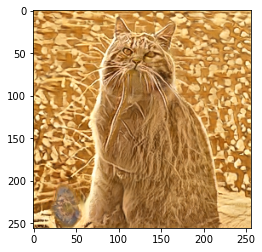

0.0
0.9507235
0.0


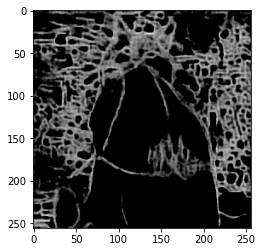

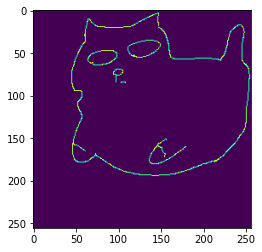

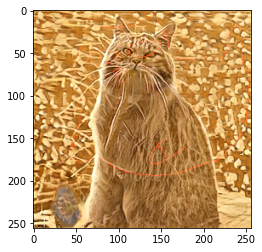

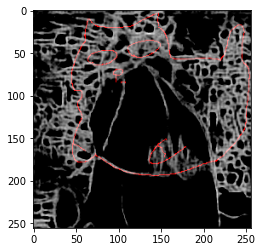

In [231]:
real_cat_img = np.array(results[0][0]).transpose(1, 2, 0)
print(np.min(real_cat_img))
print(np.max(real_cat_img))
print(np.median(real_cat_img))
plt.imshow(real_cat_img)
plt.show()

real_cat_img = np.array(results[1][0].repeat(3, 1, 1)).transpose(1, 2, 0)
print(np.min(real_cat_img))
print(np.max(real_cat_img))
print(np.median(real_cat_img))
plt.imshow(real_cat_img, cmap="gray")
plt.show()

plt.imshow(ref_im[0,0].cpu())
plt.show()

import copy
mod = copy.deepcopy(np.array(results[0][0]).transpose(1, 2, 0))
mod += ref_im[0,0].cpu().numpy()[:, :, None] * np.array([1.0, 0.0, 0.0]).reshape(1,1,3)
mod = np.clip(mod, 0, 1)
plt.imshow(mod)
plt.show()

import copy
mod = copy.deepcopy(np.array(results[1][0].repeat(3, 1, 1)).transpose(1, 2, 0))
mod += ref_im[0,0].cpu().numpy()[:, :, None] * np.array([1.0, 0.0, 0.0]).reshape(1,1,3)
mod = np.clip(mod, 0, 1)
plt.imshow(mod)
plt.show()

3


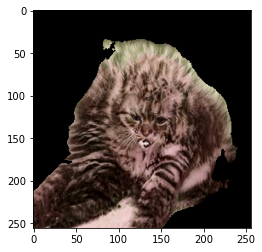

In [369]:
tmp = foreground_hard(results[0].to(device))
print(3)
plt.imshow(tmp[0].detach().cpu().numpy().transpose(1,2,0))
plt.show()

In [34]:
ref_im.mean()

tensor(0.0364, device='cuda:1')

In [43]:
pool = torch.nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

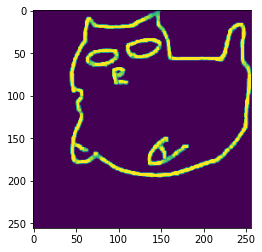

In [46]:
plt.imshow(torch.nn.functional.max_pool2d(ref_im, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)).cpu()[0, 0])